In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import boto3
import pickle

In [3]:
#load from S3 and Unpickle

bucket_name = 'tfl-cycle-data'
s3_file_path = 'Docking_station_data/Waterloo-Jan2016-Apr2024.pkl'
local_file_path = 'temp/Waterloo-Jan2016-Apr2024.pkl'
s3 = boto3.client('s3')

s3.download_file(bucket_name, s3_file_path, local_file_path)

with open(local_file_path, 'rb') as f:
    df = pickle.load(f)
df.head()

,Rental ID,Start Date,Start Station Name,End Date,End Station Name
0,50755276,2016-10-01 08:41:00,"William IV Street, Strand",2016-10-01 08:47:00,"Waterloo Station 3, Waterloo"
1,50755420,2016-10-01 09:05:00,"Bermondsey Street, Bermondsey",2016-10-01 09:15:00,"Waterloo Station 3, Waterloo"
2,50755598,2016-10-01 09:28:00,"Lollard Street, Vauxhall",2016-10-01 09:36:00,"Waterloo Station 3, Waterloo"
3,50755603,2016-10-01 09:28:00,"Lollard Street, Vauxhall",2016-10-01 09:36:00,"Waterloo Station 3, Waterloo"
4,50756101,2016-10-01 10:12:00,"Waterloo Station 3, Waterloo",2016-10-01 10:27:00,"Braham Street, Aldgate"


In [43]:
df_out.shape

(595780, 4)

In [29]:
df_out = df[df['Start Station Name'] == 'Waterloo Station 3, Waterloo']
df_out.set_index('Start Date', inplace=True)
df_rentals = df_out.resample('1H').size().reset_index(name='Rentals')

df_rentals['day_of_week'] = df_rentals['Start Date'].dt.dayofweek
df_rentals['day_of_year'] = df_rentals['Start Date'].dt.day
df_rentals['hour_of_day'] = df_rentals['Start Date'].dt.hour
# rentals_5min['Hour'] = rentals_5min['Start Date'].dt.hour

exog = pd.get_dummies(df_rentals[['day_of_week', 'day_of_year', 'hour_of_day']])

df_rentals.head(25)

,Start Date,Rentals,day_of_week,day_of_year,hour_of_day
0,2015-01-02 01:00:00,1,4,2,1
1,2015-01-02 02:00:00,0,4,2,2
2,2015-01-02 03:00:00,0,4,2,3
3,2015-01-02 04:00:00,0,4,2,4
4,2015-01-02 05:00:00,0,4,2,5
5,2015-01-02 06:00:00,0,4,2,6
6,2015-01-02 07:00:00,0,4,2,7
7,2015-01-02 08:00:00,0,4,2,8
8,2015-01-02 09:00:00,0,4,2,9
9,2015-01-02 10:00:00,0,4,2,10


In [36]:
#Use the Augmented Dickey-Fuller test to check if the series is stationary. If not, differencing may be required.
df_sample = df_rentals.sample(frac=0.05, random_state=42).sort_values('Start Date')

result = adfuller(df_sample['Rentals'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -59.8225082040541
p-value: 0.0


In [37]:
df_sample.head()

,Start Date,Rentals,day_of_week,day_of_year,hour_of_day
39,2015-01-03 16:00:00,1,5,3,16
106,2015-01-06 11:00:00,0,1,6,11
124,2015-01-07 05:00:00,0,2,7,5
127,2015-01-07 08:00:00,0,2,7,8
128,2015-01-07 09:00:00,0,2,7,9


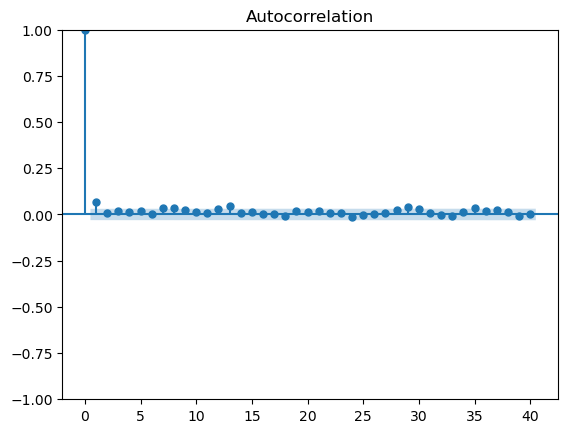

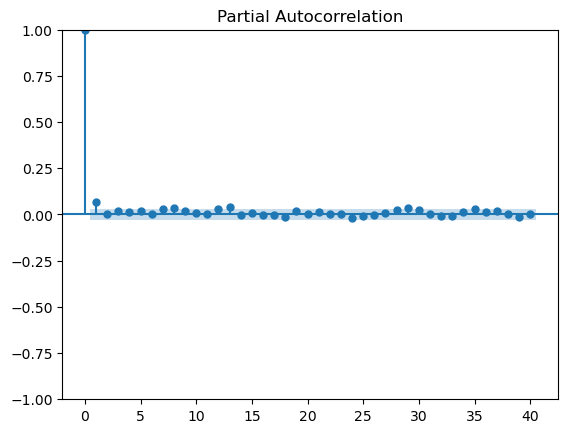

In [38]:
# Plot ACF and PACF
plot_acf(df_sample['Rentals'], lags=40)
plot_pacf(df_sample['Rentals'], lags=40)
plt.show()

Both plots drop off therefore use both AR(auto regressive) and MA(moving average) components

In [39]:
sarima_model = SARIMAX(df_sample['Rentals'],
                       order=(1, 0, 1),              # ARIMA order (p, d, q)
                       seasonal_order=(1, 1, 1, 12),  # Seasonal order (P, D, Q, m)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()

# Print the summary of the model
print(sarima_result.summary())

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72494D+00    |proj g|=  1.68191D-01

At iterate    5    f=  4.69472D+00    |proj g|=  2.88358D-02

At iterate   10    f=  4.69305D+00    |proj g|=  5.89170D-02

At iterate   15    f=  4.64529D+00    |proj g|=  2.00058D-01

At iterate   20    f=  4.60680D+00    |proj g|=  1.37312D-02

At iterate   25    f=  4.60679D+00    |proj g|=  3.01828D-04

At iterate   30    f=  4.60678D+00    |proj g|=  2.47501D-03

At iterate   35    f=  4.60677D+00    |proj g|=  5.70732D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

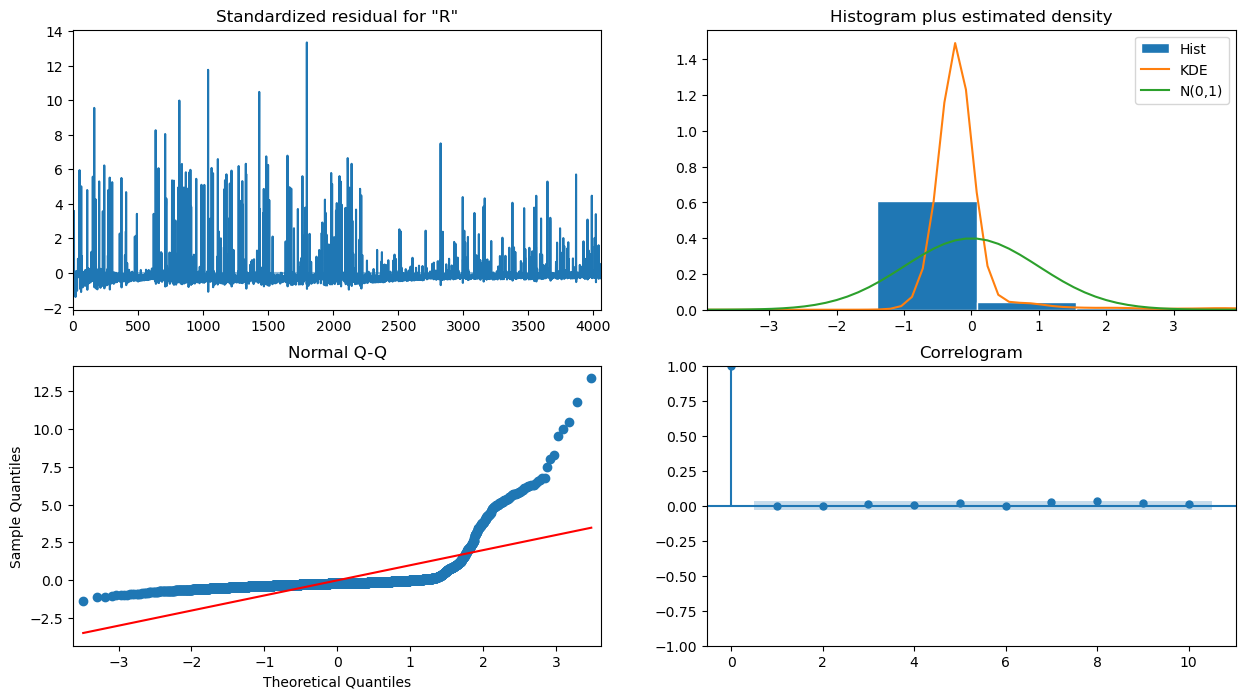

In [40]:
sarima_result.plot_diagnostics(figsize=(15, 8))
plt.show()

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


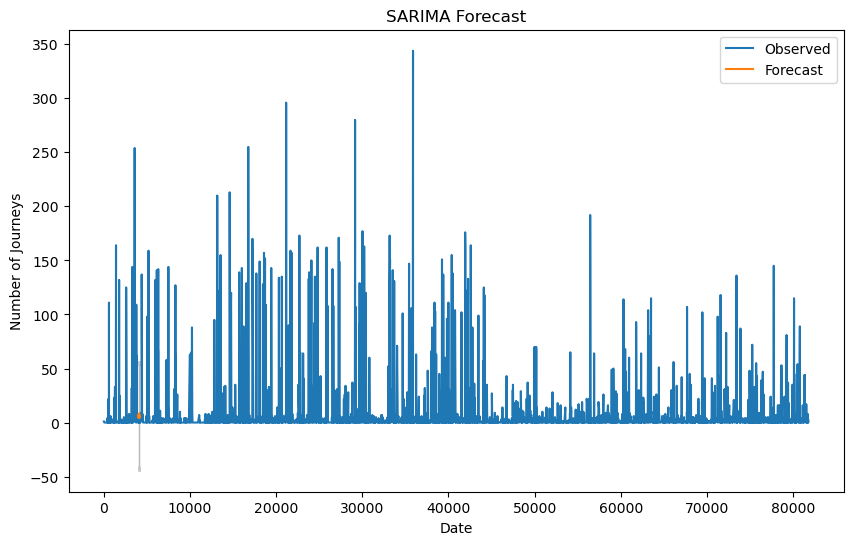

In [42]:
forecast = sarima_result.get_forecast(steps=48)
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_sample.index, df_sample['Rentals'], label='Observed')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Journeys')
plt.legend()
plt.show()